# ChessGPT

### Getting the data 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error , r2_score, accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from extended_sklearn_metrics import evaluate_model_with_cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.compose import ColumnTransformer

# modeling
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,RandomForestRegressor,
GradientBoostingRegressor, AdaBoostRegressor,StackingRegressor, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , precision_score, roc_curve,roc_auc_score, ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline

# chess board (png)
### pip install chess
import chess

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

import timeit

In [3]:
df = pd.read_csv("../Chess/games.csv")

In [4]:
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [5]:
df.duplicated().value_counts()

False    19629
True       429
Name: count, dtype: int64

In [6]:
df2 = df.drop_duplicates()
df2.duplicated().value_counts()

False    19629
Name: count, dtype: int64

In [7]:
df2.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


### Cleaning the data

In [8]:
df2['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df2['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')

df2[['created_at', 'last_move_at']]

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3355348785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3355348785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')


,created_at,last_move_at
0,2017-08-31 20:06:40.000,2017-08-31 20:06:40.000
1,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000
2,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000
3,2017-08-30 16:20:00.000,2017-08-30 16:20:00.000
4,2017-08-29 18:06:40.000,2017-08-29 18:06:40.000
...,...,...
20053,2017-07-11 16:35:14.342,2017-07-11 16:40:36.076
20054,2017-07-10 14:48:09.760,2017-07-10 15:00:33.979
20055,2017-07-10 14:44:37.493,2017-07-10 14:47:30.327
20056,2017-07-10 14:15:27.019,2017-07-10 14:31:13.718


In [9]:
df2

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,2017-08-31 20:06:40.000,2017-08-31 20:06:40.000,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,2017-08-30 16:20:00.000,2017-08-30 16:20:00.000,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,2017-08-29 18:06:40.000,2017-08-29 18:06:40.000,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,2017-07-11 16:35:14.342,2017-07-11 16:40:36.076,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,WSJDhbPl,True,2017-07-10 14:48:09.760,2017-07-10 15:00:33.979,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,yrAas0Kj,True,2017-07-10 14:44:37.493,2017-07-10 14:47:30.327,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,b0v4tRyF,True,2017-07-10 14:15:27.019,2017-07-10 14:31:13.718,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


In [10]:
encoder = LabelEncoder()

In [11]:
ordinal_cols = ["victory_status","winner","rated", 'opening_eco',"opening_name"]
for col in ordinal_cols:
    encoder.fit_transform(df2[col])
    df2[col + "_encoded"] = encoder.fit_transform(df2[col])

df2.head()

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3777938341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col + "_encoded"] = encoder.fit_transform(df2[col])
C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3777938341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col + "_encoded"] = encoder.fit_transform(df2[col])
C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3777938341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,victory_status_encoded,winner_encoded,rated_encoded,opening_eco_encoded,opening_name_encoded
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,2,2,0,248,1387
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,3,0,1,71,750
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,...,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,1,2,1,171,650
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,...,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,1,2,1,241,992
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,...,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,1,2,1,192,783


In [12]:
df2["game_duration"] = df2["last_move_at"] - df2["created_at"]

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\1517647160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["game_duration"] = df2["last_move_at"] - df2["created_at"]


In [13]:
df2["duration_seconds"] = df2["game_duration"].dt.total_seconds().round(2)

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\1257900156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["duration_seconds"] = df2["game_duration"].dt.total_seconds().round(2)


In [14]:
df2["duration_minutes"] = (df2["duration_seconds"] / 60).round(2)

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\2692895890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["duration_minutes"] = (df2["duration_seconds"] / 60).round(2)


In [15]:
df2.loc[(df2['victory_status'] == 'outoftime') & (df2['winner'] == 'draw'), 'victory_status'] = 'draw'
df2.groupby("winner")["victory_status"].value_counts()

winner  victory_status
black   resign            5199
        mate              2915
        outoftime          805
draw    draw               918
white   resign            5727
        mate              3273
        outoftime          792
Name: count, dtype: int64

In [16]:
# labelencoder not giving positive values(using manual way to change value of wbd)
df2["winner_label"] = df2["winner"].map({"white": 1, "black": 0, "draw": 0.5})

opening_stats = df2.groupby("opening_name")["winner_label"].agg(["count", "mean"])
opening_stats = opening_stats.rename(columns={"mean": "white_win_rate"})
opening_stats["black_win_rate"] = 1 - opening_stats["white_win_rate"]
opening_stats

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\4002210924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["winner_label"] = df2["winner"].map({"white": 1, "black": 0, "draw": 0.5})


,count,white_win_rate,black_win_rate
opening_name,,,
Alekhine Defense,43,0.511628,0.488372
Alekhine Defense #2,3,0.500000,0.500000
Alekhine Defense #3,1,0.000000,1.000000
Alekhine Defense: Balogh Variation,1,0.000000,1.000000
Alekhine Defense: Brooklyn Variation,2,1.000000,0.000000
...,...,...,...
Zukertort Opening: Slav Invitation,10,0.800000,0.200000
Zukertort Opening: Tennison Gambit,41,0.573171,0.426829
Zukertort Opening: The Walrus,1,1.000000,0.000000


In [17]:
reliable_openings = opening_stats[opening_stats['count'] > 100]
reliable_openings

,count,white_win_rate,black_win_rate
opening_name,,,
Bishop's Opening,128,0.570312,0.429688
Caro-Kann Defense,196,0.558673,0.441327
Four Knights Game: Italian Variation,163,0.567485,0.432515
French Defense #2,105,0.480952,0.519048
French Defense: Exchange Variation,105,0.585714,0.414286
French Defense: Knight Variation,265,0.528302,0.471698
French Defense: Normal Variation,124,0.612903,0.387097
Giuoco Piano,104,0.451923,0.548077
Horwitz Defense,208,0.540865,0.459135


In [18]:
white_top_10 = reliable_openings.sort_values("white_win_rate",ascending=False).head(10)
black_top_10 = reliable_openings.sort_values("black_win_rate",ascending=False).head(10)

In [19]:
white_top_10

,count,white_win_rate,black_win_rate
opening_name,,,
Queen's Pawn,129,0.678295,0.321705
Queen's Gambit Refused: Marshall Defense,127,0.669291,0.330709
Philidor Defense,133,0.650376,0.349624
Philidor Defense #3,188,0.648936,0.351064
Scandinavian Defense: Mieses-Kotroc Variation,253,0.640316,0.359684
Pirc Defense #4,107,0.626168,0.373832
Italian Game,107,0.626168,0.373832
French Defense: Normal Variation,124,0.612903,0.387097
Queen's Gambit Declined,114,0.596491,0.403509


In [20]:
df2['moves_list'] = df2['moves'].str.split(' ')
df2["moves_list"]

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\323917834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['moves_list'] = df2['moves'].str.split(' ')


0        [d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...
1        [d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...
2        [e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...
3        [d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...
4        [e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...
                               ...                        
20053    [d4, f5, e3, e6, Nf3, Nf6, Nc3, b6, Be2, Bb7, ...
20054    [d4, d6, Bf4, e5, Bg3, Nf6, e3, exd4, exd4, d5...
20055    [d4, d5, Bf4, Nc6, e3, Nf6, c3, e6, Nf3, Be7, ...
20056    [e4, d6, d4, Nf6, e5, dxe5, dxe5, Qxd1+, Kxd1,...
20057    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
Name: moves_list, Length: 19629, dtype: object

In [21]:
df2.moves_list

0        [d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...
1        [d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...
2        [e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...
3        [d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...
4        [e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...
                               ...                        
20053    [d4, f5, e3, e6, Nf3, Nf6, Nc3, b6, Be2, Bb7, ...
20054    [d4, d6, Bf4, e5, Bg3, Nf6, e3, exd4, exd4, d5...
20055    [d4, d5, Bf4, Nc6, e3, Nf6, c3, e6, Nf3, Be7, ...
20056    [e4, d6, d4, Nf6, e5, dxe5, dxe5, Qxd1+, Kxd1,...
20057    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
Name: moves_list, Length: 19629, dtype: object

In [22]:
df2.groupby("opening_ply")["moves_list"].size()

opening_ply
1     1077
2     2894
3     3422
4     3248
5     2672
6     1969
7     1307
8     1077
9      668
10     419
11     418
12     138
13     123
14      54
15      41
16      30
17      35
18      12
19      11
20       8
22       1
24       1
28       4
Name: moves_list, dtype: int64

In [23]:
df2["opening_moves"] = df2['moves_list'].apply(lambda x: ' '.join(x[:8]))
df2.head()

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\3253785741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["opening_moves"] = df2['moves_list'].apply(lambda x: ' '.join(x[:8]))


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,winner_encoded,rated_encoded,opening_eco_encoded,opening_name_encoded,game_duration,duration_seconds,duration_minutes,winner_label,moves_list,opening_moves
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,...,2,0,248,1387,0 days,0.0,0.0,1.0,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4 d5 c4 c6 cxd5 e6 dxe6 fxe6
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,...,0,1,71,750,0 days,0.0,0.0,0.0,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4 Nc6 e4 e5 f4 f6 dxe5 fxe5
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,...,2,1,171,650,0 days,0.0,0.0,1.0,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4 e5 d3 d6 Be3 c6 Be2 b5
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,...,2,1,241,992,0 days,0.0,0.0,1.0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,...,2,1,192,783,0 days,0.0,0.0,1.0,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4 e5 Nf3 d6 d4 Nc6 d5 Nb4


In [24]:
opening_stats = df2.groupby(["opening_moves", 'winner']).size().unstack(fill_value=0)
opening_stats

winner,black,draw,white
opening_moves,,,
Na3 Nf6 b3 e5 e3 Nc6 c4 Be7,1,0,0
Na3 e5 Nb5 Qh4 g3 Qe4 Nf3 Na6,1,0,0
Na3 e5 Rab1,0,0,1
Na3 e5 e3 Bxa3 Qh5 Bxb2 Bxb2 Qe7,1,0,0
Nc3 Nc6,0,0,1
...,...,...,...
h4 e5 g3 d5 f4 Nc6 Bh3 f5,0,1,0
h4 e5 h5 d5 Rh3 f6 Nf3 c5,1,0,0
h4 e5 h5 d5 e3 Nf6 f3 e4,1,0,0


In [25]:
opening_stats['total_games'] = opening_stats['white'] + opening_stats['black'] + opening_stats['draw']

In [26]:
opening_stats['white_win_rate'] = (opening_stats['white'] / opening_stats['total_games']) * 100
opening_stats['black_win_rate'] = (opening_stats['black'] / opening_stats['total_games']) * 100
opening_stats['draw_rate'] = (opening_stats['draw'] / opening_stats['total_games']) * 100
opening_stats['total_games']

opening_moves
Na3 Nf6 b3 e5 e3 Nc6 c4 Be7         1
Na3 e5 Nb5 Qh4 g3 Qe4 Nf3 Na6       1
Na3 e5 Rab1                         1
Na3 e5 e3 Bxa3 Qh5 Bxb2 Bxb2 Qe7    1
Nc3 Nc6                             1
                                   ..
h4 e5 g3 d5 f4 Nc6 Bh3 f5           1
h4 e5 h5 d5 Rh3 f6 Nf3 c5           1
h4 e5 h5 d5 e3 Nf6 f3 e4            1
h4 e5 h5 h6 Nc3 Qf6 Nd5 Qc6         1
h4 e6 g3 d5 Bh3 c5 d3 Nc6           1
Name: total_games, Length: 13148, dtype: int64

In [27]:
# sorting
opening_stats = opening_stats.sort_values(by='total_games', ascending=False)
opening_stats

winner,black,draw,white,total_games,white_win_rate,black_win_rate,draw_rate
opening_moves,,,,,,,
e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6,114,14,146,274,53.284672,41.605839,5.109489
e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5,56,2,54,112,48.214286,50.000000,1.785714
e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6,57,10,39,106,36.792453,53.773585,9.433962
e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nxd4,47,7,47,101,46.534653,46.534653,6.930693
e4 e6 d4 d5 e5 c5 c3 Nc6,43,7,41,91,45.054945,47.252747,7.692308
...,...,...,...,...,...,...,...
d4 e5 d5 Ke7 Nf3 f6 e4 Kf7,0,0,1,1,100.000000,0.000000,0.000000
d4 e5 d5 Nf6 c4 Bc5 Nc3 O-O,1,0,0,1,0.000000,100.000000,0.000000
d4 e5 d5 f6 a3 c6 Nc3 cxd5,1,0,0,1,0.000000,100.000000,0.000000


In [28]:
opening_stats = opening_stats[opening_stats['total_games'] >= 30]
opening_stats

winner,black,draw,white,total_games,white_win_rate,black_win_rate,draw_rate
opening_moves,,,,,,,
e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6,114,14,146,274,53.284672,41.605839,5.109489
e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5,56,2,54,112,48.214286,50.000000,1.785714
e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6,57,10,39,106,36.792453,53.773585,9.433962
e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nxd4,47,7,47,101,46.534653,46.534653,6.930693
e4 e6 d4 d5 e5 c5 c3 Nc6,43,7,41,91,45.054945,47.252747,7.692308
e4 e5 Nf3 Nc6 Bb5 a6 Bxc6 dxc6,36,6,42,84,50.000000,42.857143,7.142857
d4 Nf6 c4 g6 Nc3 Bg7 e4 d6,34,4,36,74,48.648649,45.945946,5.405405
e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Bc5,31,1,33,65,50.769231,47.692308,1.538462
e4 e5 Nf3 Nc6 Bc4 Bc5 c3 Nf6,30,3,25,58,43.103448,51.724138,5.172414


## Prediction

In [29]:
51121

51121

### Classifier

In [30]:
test = opening_stats.reset_index()
test

winner,opening_moves,black,draw,white,total_games,white_win_rate,black_win_rate,draw_rate
0,e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6,114,14,146,274,53.284672,41.605839,5.109489
1,e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5,56,2,54,112,48.214286,50.000000,1.785714
2,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6,57,10,39,106,36.792453,53.773585,9.433962
3,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nxd4,47,7,47,101,46.534653,46.534653,6.930693
4,e4 e6 d4 d5 e5 c5 c3 Nc6,43,7,41,91,45.054945,47.252747,7.692308
5,e4 e5 Nf3 Nc6 Bb5 a6 Bxc6 dxc6,36,6,42,84,50.000000,42.857143,7.142857
6,d4 Nf6 c4 g6 Nc3 Bg7 e4 d6,34,4,36,74,48.648649,45.945946,5.405405
7,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Bc5,31,1,33,65,50.769231,47.692308,1.538462
8,e4 e5 Nf3 Nc6 Bc4 Bc5 c3 Nf6,30,3,25,58,43.103448,51.724138,5.172414
9,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5,16,3,37,56,66.071429,28.571429,5.357143


In [31]:
x = df2['opening_moves']
y = df2['winner']

In [32]:
x

0          d4 d5 c4 c6 cxd5 e6 dxe6 fxe6
1           d4 Nc6 e4 e5 f4 f6 dxe5 fxe5
2              e4 e5 d3 d6 Be3 c6 Be2 b5
3          d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4
4             e4 e5 Nf3 d6 d4 Nc6 d5 Nb4
                      ...               
20053         d4 f5 e3 e6 Nf3 Nf6 Nc3 b6
20054       d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4
20055         d4 d5 Bf4 Nc6 e3 Nf6 c3 e6
20056    e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+
20057         d4 d5 Bf4 Na6 e3 e6 c3 Nf6
Name: opening_moves, Length: 19629, dtype: object

In [33]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [34]:
X_tfidf = tfidf.fit_transform(x)

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=42)

In [36]:
# # XGBoost model
# from xgboost import XGBClassifier

# clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# clf.fit(X_train, y_train)


In [37]:
# y_pred = clf.predict(X_test)

# print("🔥 Accuracy:", accuracy_score(y_test, y_pred))
# print("\n🚀 Classification Report:\n", classification_report(y_test, y_pred))

In [38]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

In [39]:
# y_pred = model.predict(X_test)
# y_pred

In [40]:
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [41]:
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Black', 'White', 'Draw'])
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix 🍽️')
# plt.show()

In [42]:
########################################################################

In [43]:
# model = RandomForestClassifier(
#     n_estimators=300,         
#     max_depth=15,             
#     min_samples_split=5,      
#     min_samples_leaf=2,       
#     max_features='sqrt',      
#     bootstrap=True,           
#     random_state=42           
# )
# model.fit(X_train, y_train)

In [44]:
# scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
# print(f'Cross-validation scores: {scores}')
# print(f'Mean CV Accuracy: {np.mean(scores):.4f}')

In [45]:
##########################################################################

In [46]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost Classifier": XGBClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network (MLP)": MLPClassifier(max_iter=1000),
}

In [47]:
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [48]:
X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

In [49]:
results = []

for name, model in models.items():
    pipeline = Pipeline([
        # ("preprocessor", preprocessor),  # Optional if you have feature processing
        ("classifier", model)
    ])
    pipeline.fit(X_train_dense, y_train_encoded)
    y_pred = pipeline.predict(X_test_dense)

    y_pred_lab = encoder.inverse_transform(y_pred)
    
    results.append({
        "model": name,
        "Accuracy": accuracy_score(y_test, y_pred_lab),
        "F1_Score": f1_score(y_test, y_pred_lab, average="weighted"),  # weighted for multi-class
        "Confusion_Matrix": confusion_matrix(y_test, y_pred_lab)
    })

c:\Users\EeSze\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [50]:
results = pd.DataFrame(results).sort_values(by="F1_Score", ascending=False)
results

,model,Accuracy,F1_Score,Confusion_Matrix
4,Random Forest Classifier,0.529632,0.519228,"[[1317, 15, 1338], [110, 14, 159], [1127, 21, ..."
1,Support Vector Classifier,0.535745,0.518342,"[[1221, 0, 1449], [107, 0, 176], [1002, 0, 1934]]"
7,XGBoost Classifier,0.528443,0.511430,"[[1197, 3, 1470], [108, 1, 174], [1022, 0, 1914]]"
0,Logistic Regression,0.527084,0.509218,"[[1177, 0, 1493], [115, 0, 168], [1009, 0, 1927]]"
6,Gradient Boosting Classifier,0.533367,0.501689,"[[904, 9, 1757], [81, 2, 200], [696, 5, 2235]]"
9,Neural Network (MLP),0.508575,0.500695,"[[1236, 54, 1380], [110, 14, 159], [1133, 58, ..."
3,K-Nearest Neighbors,0.505349,0.494962,"[[1355, 15, 1300], [149, 3, 131], [1299, 19, 1..."
5,AdaBoost Classifier,0.520971,0.491167,"[[910, 3, 1757], [96, 0, 187], [774, 4, 2158]]"
2,Decision Tree Classifier,0.496349,0.490863,"[[1406, 50, 1214], [145, 13, 125], [1362, 70, ..."
8,Naive Bayes,0.089828,0.086853,"[[128, 2487, 55], [7, 267, 9], [116, 2686, 134]]"


In [51]:
###################TESTING FOR IMPROVEMENT IN SCORES#######################

In [52]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42))
])

In [53]:
##########################################################################

### Regression

In [54]:
x2 = df2['opening_moves']
y2 = df2['winner_encoded']

In [55]:
X_tfidf_2 = tfidf.fit_transform(x2)

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf_2,y2,test_size=0.3,random_state=42)

In [57]:
cat_cols = x2.unique()
cat_cols

array(['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6', 'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5',
       'e4 e5 d3 d6 Be3 c6 Be2 b5', ..., 'd4 d6 Bf4 e5 Bg3 Nf6 e3 exd4',
       'd4 d5 Bf4 Nc6 e3 Nf6 c3 e6', 'd4 d5 Bf4 Na6 e3 e6 c3 Nf6'],
      dtype=object)

In [58]:
preprocessor = ColumnTransformer([("cat",OneHotEncoder(drop="first"),cat_cols)],remainder="passthrough")

In [59]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "KNN Regression": KNeighborsRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "AdaBoost Regression": AdaBoostRegressor(),
    "XGBoost Regression": xgb.XGBRegressor(),
}

In [60]:
results = []

for name,model in models.items():
    pipeline = Pipeline([
        # ("preprocessor",preprocessor),
        ("regressor",model)
    ])
    pipeline.fit(X_train,y_train)
    y_pred2 = pipeline.predict(X_test)
    results.append({
        "model":name,
        "R2_score":r2_score(y_test,y_pred2),
        "MSE": mean_squared_error(y_test,y_pred2)
    })

In [61]:
results = pd.DataFrame(results)
results.sort_values(by="R2_score" ,ascending=False)

,model,R2_score,MSE
1,Ridge Regression,0.012840,0.937707
0,Linear Regression,0.008978,0.941376
2,Lasso Regression,-0.000001,0.949905
7,AdaBoost Regression,-0.000082,0.949982
8,XGBoost Regression,-0.011909,0.961217
6,Random Forest Regression,-0.083773,1.029481
5,KNN Regression,-0.145866,1.088463
3,Support Vector Regression,-0.195904,1.135994
4,Decision Tree Regression,-0.528867,1.452277


In [62]:
# <!-- ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++= -->

In [63]:
x3 = tfidf.fit_transform(opening_stats.index)
y3 = opening_stats[['white_win_rate', 'black_win_rate', 'draw_rate']]

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2, random_state=42)


In [64]:
model = MultiOutputRegressor(RandomForestRegressor())
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [65]:
y_pred = model.predict(X_test)

In [66]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.13058022524961702
MAE: 6.193883743997055
MSE: 76.94037135778198


In [67]:
########################################################################

In [68]:
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from xgboost import XGBRegressor
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# # 1. TF-IDF vectorization with n-grams
# vectorizer = TfidfVectorizer(ngram_range=(1,3))  # unigrams + bigrams + trigrams
# X = vectorizer.fit_transform(opening_stats.index)  # opening sequences
# y = opening_stats['white']  # example: predicting white win rate (you can switch to any target)

# # 2. Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

# # 3. Model training
# model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=24)
# model.fit(X_train, y_train)

# # 4. Predictions
# y_pred = model.predict(X_test)

# # 5. Evaluation
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)

# print(f" R2 Score: {r2}")
# print(f" MAE: {mae}")
# print(f" MSE: {mse}")


# Grouping and cleaning [TESTING]

In [69]:
base_minutes = []
increment_seconds = []

for i in df2["increment_code"]:
    a, b = i.split("+")
    base_minutes.append(int(a))
    increment_seconds.append(int(b))

df2["base_minutes"] = base_minutes
df2["increment_seconds"] = increment_seconds

C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\598891872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["base_minutes"] = base_minutes
C:\Users\EeSze\AppData\Local\Temp\ipykernel_68396\598891872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["increment_seconds"] = increment_seconds


In [70]:
df2.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,opening_eco_encoded,opening_name_encoded,game_duration,duration_seconds,duration_minutes,winner_label,moves_list,opening_moves,base_minutes,increment_seconds
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,...,248,1387,0 days,0.0,0.0,1.0,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4 d5 c4 c6 cxd5 e6 dxe6 fxe6,15,2
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,...,71,750,0 days,0.0,0.0,0.0,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4 Nc6 e4 e5 f4 f6 dxe5 fxe5,5,10
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,...,171,650,0 days,0.0,0.0,1.0,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4 e5 d3 d6 Be3 c6 Be2 b5,5,10
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,...,241,992,0 days,0.0,0.0,1.0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4,20,0
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,...,192,783,0 days,0.0,0.0,1.0,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4 e5 Nf3 d6 d4 Nc6 d5 Nb4,30,3


In [71]:
opening_map = df2.set_index('opening_moves')['opening_name'].to_dict()
opening_map

{'d4 d5 c4 c6 cxd5 e6 dxe6 fxe6': 'Slav Defense: Exchange Variation',
 'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5': 'Nimzowitsch Defense: Kennedy Variation',
 'e4 e5 d3 d6 Be3 c6 Be2 b5': "King's Pawn Game: Leonardis Variation",
 'd4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4': "Queen's Pawn Game: Zukertort Variation",
 'e4 e5 Nf3 d6 d4 Nc6 d5 Nb4': 'Philidor Defense',
 'e4 c5 Nf3 Qa5 a3': 'Sicilian Defense: Mongoose Variation',
 'd4 d5 e4 dxe4 Nc3 Nf6 f3 exf3': 'Blackmar-Diemer Gambit: Ryder Gambit',
 'e4 Nc6 d4 e5 d5 Nce7 c3 Ng6': 'Nimzowitsch Defense: Kennedy Variation |  Linksspringer Variation',
 'e4 e5 Bc4 Nc6 Nf3 Nd4 d3 Nxf3+': 'Italian Game: Schilling-Kostic Gambit',
 'e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6': 'Scandinavian Defense: Mieses-Kotroc Variation',
 'e3 e6 d4 d6 Bd3 c6 Nf3 Be7': "Van't Kruijs Opening",
 'e4 e6 d4 d5 e5 c5 c3 Nc6': 'French Defense: Advance Variation |  Euwe Variation',
 'e4 e6 Nf3 d5 exd5 exd5 Qe2+ Be7': 'French Defense: Knight Variation',
 'e4 e6 Qh5 g6 Qe5 Nf6 d4 d6': 'French Defense #

In [72]:
opening_stats

winner,black,draw,white,total_games,white_win_rate,black_win_rate,draw_rate
opening_moves,,,,,,,
e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6,114,14,146,274,53.284672,41.605839,5.109489
e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5,56,2,54,112,48.214286,50.000000,1.785714
e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6,57,10,39,106,36.792453,53.773585,9.433962
e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nxd4,47,7,47,101,46.534653,46.534653,6.930693
e4 e6 d4 d5 e5 c5 c3 Nc6,43,7,41,91,45.054945,47.252747,7.692308
e4 e5 Nf3 Nc6 Bb5 a6 Bxc6 dxc6,36,6,42,84,50.000000,42.857143,7.142857
d4 Nf6 c4 g6 Nc3 Bg7 e4 d6,34,4,36,74,48.648649,45.945946,5.405405
e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Bc5,31,1,33,65,50.769231,47.692308,1.538462
e4 e5 Nf3 Nc6 Bc4 Bc5 c3 Nf6,30,3,25,58,43.103448,51.724138,5.172414


In [73]:
df2

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,opening_eco_encoded,opening_name_encoded,game_duration,duration_seconds,duration_minutes,winner_label,moves_list,opening_moves,base_minutes,increment_seconds
0,TZJHLljE,False,2017-08-31 20:06:40.000,2017-08-31 20:06:40.000,13,outoftime,white,15+2,bourgris,1500,...,248,1387,0 days 00:00:00,0.00,0.00,1.0,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4 d5 c4 c6 cxd5 e6 dxe6 fxe6,15,2
1,l1NXvwaE,True,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000,16,resign,black,5+10,a-00,1322,...,71,750,0 days 00:00:00,0.00,0.00,0.0,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4 Nc6 e4 e5 f4 f6 dxe5 fxe5,5,10
2,mIICvQHh,True,2017-08-30 21:53:20.000,2017-08-30 21:53:20.000,61,mate,white,5+10,ischia,1496,...,171,650,0 days 00:00:00,0.00,0.00,1.0,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4 e5 d3 d6 Be3 c6 Be2 b5,5,10
3,kWKvrqYL,True,2017-08-30 16:20:00.000,2017-08-30 16:20:00.000,61,mate,white,20+0,daniamurashov,1439,...,241,992,0 days 00:00:00,0.00,0.00,1.0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4,20,0
4,9tXo1AUZ,True,2017-08-29 18:06:40.000,2017-08-29 18:06:40.000,95,mate,white,30+3,nik221107,1523,...,192,783,0 days 00:00:00,0.00,0.00,1.0,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4 e5 Nf3 d6 d4 Nc6 d5 Nb4,30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,2017-07-11 16:35:14.342,2017-07-11 16:40:36.076,24,resign,white,10+10,belcolt,1691,...,61,191,0 days 00:05:21.734000,321.73,5.36,1.0,"[d4, f5, e3, e6, Nf3, Nf6, Nc3, b6, Be2, Bb7, ...",d4 f5 e3 e6 Nf3 Nf6 Nc3 b6,10,10
20054,WSJDhbPl,True,2017-07-10 14:48:09.760,2017-07-10 15:00:33.979,82,mate,black,10+0,jamboger,1233,...,37,960,0 days 00:12:24.219000,744.22,12.40,0.0,"[d4, d6, Bf4, e5, Bg3, Nf6, e3, exd4, exd4, d5...",d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4,10,0
20055,yrAas0Kj,True,2017-07-10 14:44:37.493,2017-07-10 14:47:30.327,35,mate,white,10+0,jamboger,1219,...,239,977,0 days 00:02:52.834000,172.83,2.88,1.0,"[d4, d5, Bf4, Nc6, e3, Nf6, c3, e6, Nf3, Be7, ...",d4 d5 Bf4 Nc6 e3 Nf6 c3 e6,10,0
20056,b0v4tRyF,True,2017-07-10 14:15:27.019,2017-07-10 14:31:13.718,109,resign,white,10+0,marcodisogno,1360,...,78,806,0 days 00:15:46.699000,946.70,15.78,1.0,"[e4, d6, d4, Nf6, e5, dxe5, dxe5, Qxd1+, Kxd1,...",e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+,10,0


# Model

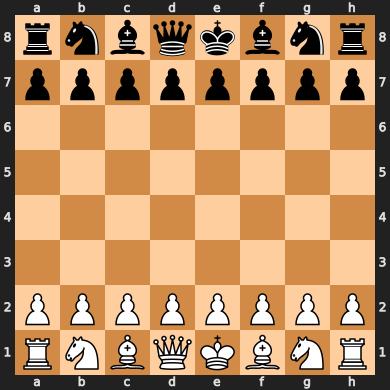

In [74]:
board = chess.Board()
board

In [75]:
for move in board.legal_moves:
    print(move.uci())

g1h3
g1f3
b1c3
b1a3
h2h3
g2g3
f2f3
e2e3
d2d3
c2c3
b2b3
a2a3
h2h4
g2g4
f2f4
e2e4
d2d4
c2c4
b2b4
a2a4


In [76]:
# =============================================================================================#

### History calling Function to check openings and win rate

In [77]:
# GPT
def live_predict_opening(current_moves):
    for i in range(len(current_moves), 0, -1):
        partial_sequence = ' '.join(current_moves[:i])

        for opening in opening_stats.index:
            if opening.startswith(partial_sequence):
                stats = opening_stats.loc[opening]

                white_win_rate = stats["white_win_rate"]
                black_win_rate = stats["black_win_rate"]
                draw_rate = stats["draw_rate"]

                # Try to find the opening name from dictionary
                opening_name = opening_map.get(' '.join(opening.split()[:i]), "Unknown Opening")

                return {
                    'matched_moves': opening,
                    'opening_name': opening_name,
                    'white_win_rate': white_win_rate.round(2),
                    'black_win_rate': black_win_rate.round(2),
                    'draw_rate': draw_rate.round(2),
                    'message': f'Matched {i} moves! ✅'
                }
    
    return {
        'matched_moves': None,
        'opening_name': None,
        'white_win_rate': None,
        'black_win_rate': None,
        'draw_rate': None,
        'message': 'No matching opening found yet'
    }


In [78]:
current_moves = []

# simulate you playing moves
current_moves.append('e4')
print(live_predict_opening(current_moves))

current_moves.append('e5')
print(live_predict_opening(current_moves))

current_moves.append('Nf3')
print(live_predict_opening(current_moves))

current_moves.append('Nc6')
print(live_predict_opening(current_moves))

current_moves.append('Bb5')
print(live_predict_opening(current_moves))


{'matched_moves': 'e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6', 'opening_name': "King's Pawn", 'white_win_rate': 53.28, 'black_win_rate': 41.61, 'draw_rate': 5.11, 'message': 'Matched 1 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Pawn Game", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 2 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Knight Opening", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 3 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Knight Opening: Normal Variation", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 4 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6', 'opening_name': 'Ruy Lopez', 'white_win_rate': 36.79, 'black_win_rate': 53.77, 'draw_rate': 9.43, 'message': 'Matched 5 moves! ✅'}


In [79]:
test_moves = ['e4', 'e5', 'Nf3', 'Nc6', 'Bb5', 'a6']
for i in range(len(test_moves)):
    print(live_predict_opening(test_moves[:i+1]))

{'matched_moves': 'e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6', 'opening_name': "King's Pawn", 'white_win_rate': 53.28, 'black_win_rate': 41.61, 'draw_rate': 5.11, 'message': 'Matched 1 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Pawn Game", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 2 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Knight Opening", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 3 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5', 'opening_name': "King's Knight Opening: Normal Variation", 'white_win_rate': 48.21, 'black_win_rate': 50.0, 'draw_rate': 1.79, 'message': 'Matched 4 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6', 'opening_name': 'Ruy Lopez', 'white_win_rate': 36.79, 'black_win_rate': 53.77, 'draw_rate': 9.43, 'message': 'Matched 5 moves! ✅'}
{'matched_moves': 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf

### Interactive Testing (fake game in notebook)

In [80]:
# current_moves = []

# while True:
#     move = input("Enter next move (or 'quit' to exit): ")
#     if move.lower() == 'quit':
#         break
#     current_moves.append(move)
#     prediction = live_predict_opening(current_moves)
#     print(prediction)


In [81]:
# ==============================================================================#

### shows the board based on prediction but not the scores

In [82]:
def live_predict_opening(current_moves, opening_stats, opening_map):
    # Initialize the board
    board = chess.Board()

    # Play the moves on the board
    for move in current_moves:
        try:
            board.push_san(move)  # Push each move in Standard Algebraic Notation
        except ValueError:
            continue  # Skip invalid moves if any

    # Predict the opening based on the moves
    for i in range(len(current_moves), 0, -1):
        partial_sequence = ' '.join(current_moves[:i])

        for opening in opening_stats.index:
            if opening.startswith(partial_sequence):
                stats = opening_stats.loc[opening]

                white_win_rate = stats["white_win_rate"]
                black_win_rate = stats["black_win_rate"]
                draw_rate = stats["draw_rate"]

                # Try to find the opening name from the dictionary
                opening_name = opening_map.get(' '.join(opening.split()[:i]), "Unknown Opening")

                prediction_message = f'Matched {i} moves! ✅'
                # return {
                #     'matched_moves': opening,
                #     'opening_name': opening_name,
                #     'white_win_rate': white_win_rate.round(2),
                #     'black_win_rate': black_win_rate.round(2),
                #     'draw_rate': draw_rate.round(2),
                #     'message': prediction_message,
                #     'board': board
                # }
                return board

    return {
        'matched_moves': None,
        'opening_name': None,
        'white_win_rate': None,
        'black_win_rate': None,
        'draw_rate': None,
        'message': 'No matching opening found yet',
        'board': board
    }


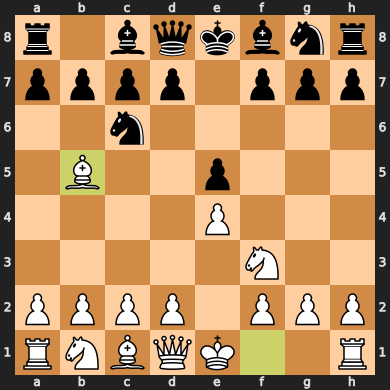

In [83]:
result = live_predict_opening(current_moves, opening_stats, opening_map)
result

In [84]:
for move in result.legal_moves:
    print(move.uci())

g8e7
g8h6
g8f6
f8e7
f8d6
f8c5
f8b4
f8a3
e8e7
d8e7
d8f6
d8g5
d8h4
a8b8
c6b8
c6e7
c6a5
c6d4
c6b4
h7h6
g7g6
f7f6
d7d6
b7b6
a7a6
h7h5
g7g5
f7f5
d7d5
a7a5


# Visualizing 

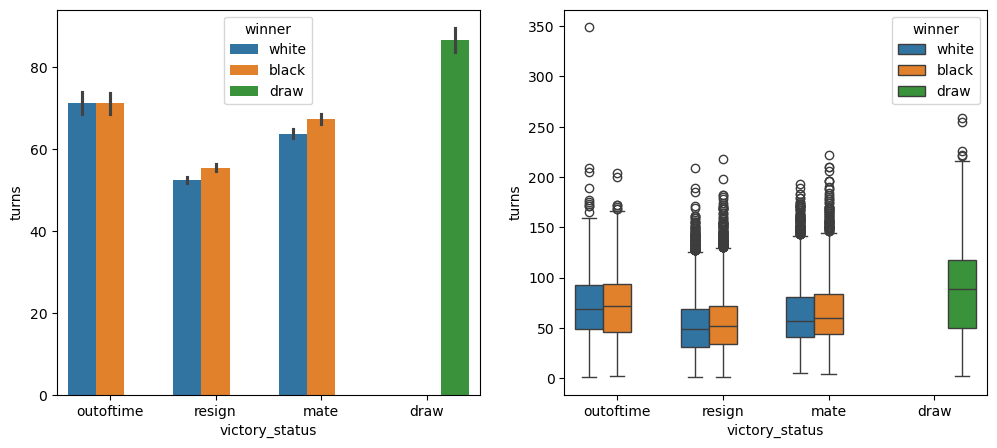

In [85]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.barplot(df2,y="turns",x="victory_status",hue="winner")
plt.subplot(122)
sns.boxplot(df2,y="turns",x="victory_status",hue="winner")
plt.show()

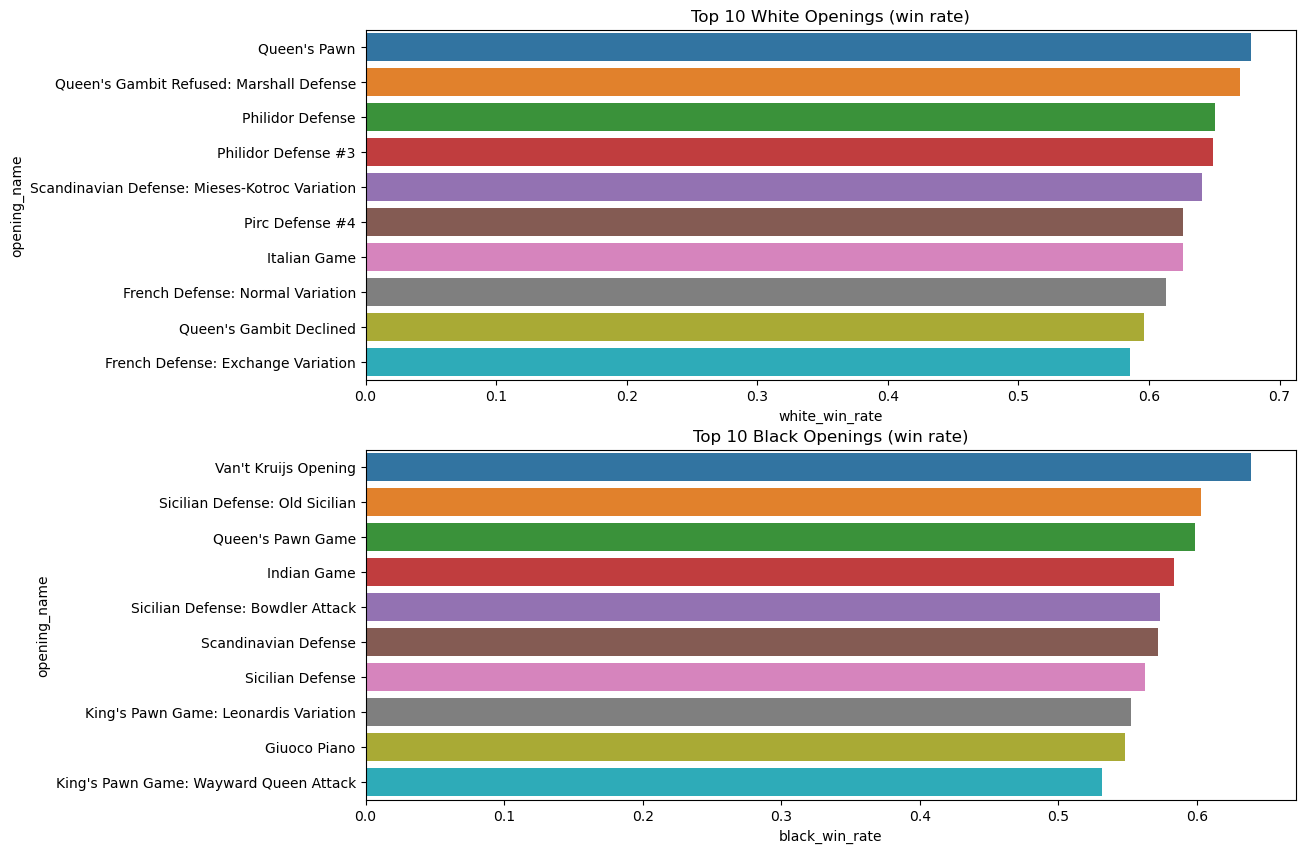

In [86]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.title("Top 10 White Openings (win rate)")
sns.barplot(white_top_10,x="white_win_rate",y="opening_name",hue="opening_name")

plt.subplot(212)
plt.title("Top 10 Black Openings (win rate)")
sns.barplot(black_top_10,x="black_win_rate",y="opening_name",hue="opening_name")

plt.show()

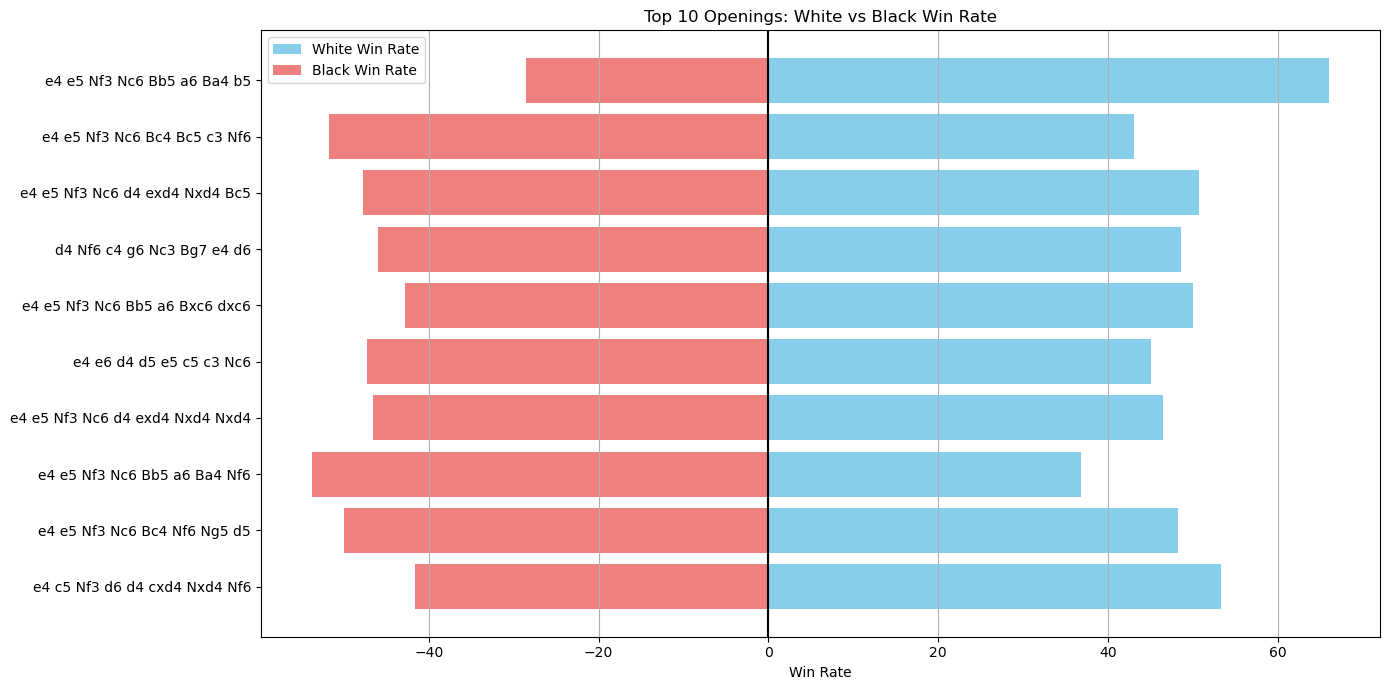

In [87]:
top_openings = opening_stats.head(10)

plt.figure(figsize=(14, 7))
plt.barh(top_openings.index, top_openings['white_win_rate'], color='skyblue', label='White Win Rate')
plt.barh(top_openings.index, -top_openings['black_win_rate'], color='lightcoral', label='Black Win Rate')  # Negative for left side

plt.xlabel('Win Rate')
plt.title('Top 10 Openings: White vs Black Win Rate')
plt.legend()
plt.grid(axis='x')
plt.axvline(0, color='black')  # Middle line
plt.tight_layout()
plt.show()